# GNN Goal Recognition
Questo notebook addestra una Graph Neural Network per il riconoscimento del goal di un agente che si muove su mappe a griglia 4-connected

## Setup e Import

In [35]:
#pip install torch_geometric
#pip install wandb -qU
#pip install networkx==3.4.2
#pip install torchinfo

In [36]:
# --- 1. Python Standard Library ---
import json
import math
import os
import pprint
import random
from dataclasses import dataclass
from typing import List, Tuple

# --- 2. Third-Party Scientific & Utilities ---
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import networkx as nx
import numpy as np
import wandb
from sklearn.manifold import TSNE

# --- 3. PyTorch Core ---
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split

# --- 4. PyTorch Geometric (GNNs) & Scatter ---
# Data handling
from torch_geometric.data import Data, Dataset, InMemoryDataset
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_networkx, softmax as pyg_softmax
from torch_geometric.utils import get_laplacian, to_scipy_sparse_matrix

# Neural Network Layers
from torch_geometric.nn import GCNConv, GraphNorm

# Scatter operations (often needed for custom aggregations)
from torch_scatter import scatter_max, scatter_sum, scatter_mean

import scipy.sparse.linalg as linalg
import pandas as pd
import seaborn as sns

In [37]:
def set_seed(seed: int = 42):
    """
    Fissa il seed per garantire la riproducibilità degli esperimenti.
    """
    # 1. Python standard
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    
    # 2. NumPy
    np.random.seed(seed)
    
    # 3. PyTorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # Se usi più GPU
    
    # 4. CuDNN (Algoritmi di convoluzione)
    # Rende il training deterministico, ma potrebbe rallentare leggermente
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    print(f"Seed fissato globalmente a: {seed}")

# --- CHIAMA LA FUNZIONE SUBITO ---
set_seed(42)

Seed fissato globalmente a: 42


## Data Loading & Processing

In [38]:
@dataclass
class Map:
    V: List[List[Tuple[int, int, int]]]
    E: List[Tuple[int, int]]
    Y: List[List[int]]
    O: List[List[int]]
    Optimality: List[float]
    AvgLength: float
    ObstaclePerc: float

In [39]:
class MyDataset(InMemoryDataset):
    def __init__(self, data_list, transform=None):
        super().__init__('.', transform)
        self.data, self.slices = self.collate(data_list)

    @property
    def num_features(self):
        return self[0].num_node_features

    @property
    def num_classes(self):
        y_all = torch.cat([d.y for d in self])
        return int(y_all.max().item() + 1)

In [40]:
def load_maps_from_drive_unified(type,size):
    """
    Carica tutte le istanze di Map insieme dal file unified
    Restituisce una lista di oggetti Map.
    """
    if size not in [8, 16, 32, 128]:
        print("size deve essere 16, 32 o 128")
        return []

    all_maps = []
    file_path = f"{type}{size}.json"
    try:
        with open(file_path, "r") as f:
            data = json.load(f)
    except (FileNotFoundError, json.JSONDecodeError):
        print(f"File {file_path} non trovato o non leggibile")
        return None

    if not data:
        print(f"File {file_path} vuoto")
        return None


    all_maps.extend([Map(**map_dict) for map_dict in data])

    return all_maps

In [41]:
class GoalRecognitionDataset(Dataset):
    def __init__(self, maps, transform=None):
        super().__init__(None, transform)
        self.maps = maps

    def _compute_pe(self, edge_index_tensor, num_nodes, k_dim=4):
        """
        Calcola i Positional Encodings una volta sola per la mappa corrente.
        """
        # 1. Laplaciano
        L_edge_index, L_edge_weight = get_laplacian(
            edge_index_tensor, 
            normalization='sym', 
            num_nodes=num_nodes
        )
        
        # 2. Converti a SciPy
        L = to_scipy_sparse_matrix(L_edge_index, L_edge_weight, num_nodes)

        # 3. Eigendecomposition
        try:
            # k_dim + 1 perché il primo è banale
            eig_vals, eig_vecs = linalg.eigsh(L, k=k_dim + 1, which='SM', tol=1e-2)
            pe = torch.from_numpy(eig_vecs[:, 1:]).float() # Scarta il primo
        except:
            # Fallback se il grafo è troppo piccolo o disconnesso
            pe = torch.zeros((num_nodes, k_dim))
        
        # Padding se necessario
        if pe.shape[1] < k_dim:
            padding = torch.zeros((num_nodes, k_dim - pe.shape[1]))
            pe = torch.cat([pe, padding], dim=1)

        # Sign Flipping (Randomizzazione del segno per robustezza)
        # Nota: Se vuoi risultati deterministici per validazione, togli questo blocco o fissa il seed
        sign = 2 * torch.randint(0, 2, (1, k_dim)) - 1
        pe = pe * sign
        
        return pe

    def generate_entries(self, map_index, path_index, print_or_not, percentage=100):
        entries = []
        
        current_map = self.maps[map_index]
        
        edge_index = torch.tensor(current_map.E, dtype=torch.long).t().contiguous()
        num_nodes = len(current_map.V[path_index])
        
        pe = self._compute_pe(edge_index, num_nodes, k_dim=4) 

        len_entr = len(current_map.O[path_index])
        new_len = int((100-percentage)*len_entr/100)
        if new_len < 2:
            new_len = 2

        for step in range(new_len, len_entr+1):
            V_mod = [row.copy() for row in current_map.V[path_index]]

            visited = current_map.O[path_index][:step-1]
            agent_pos = current_map.O[path_index][step-1]
            future = current_map.O[path_index][step:]

            if(print_or_not):
                print(visited)

            for v in visited:
                V_mod[v] = [0,0,1]

            V_mod[agent_pos] = [0,1,0]

            for f in future:
                V_mod[f] = [1,0,0]

            x_base = torch.tensor(V_mod, dtype=torch.float)
            
            x_final = torch.cat([x_base, pe], dim=1)

            y = torch.tensor(current_map.Y[path_index], dtype=torch.float)
            alpha = 6.0
            y_transformed = y ** alpha
            y_transformed = y_transformed / y_transformed.sum()

            data_item = Data(x=x_final, edge_index=edge_index, y=y_transformed)

            #Aggiunta dei metadati
            val_obstacle_perc = current_map.ObstaclePerc
            val_avg_len = current_map.AvgLength
            val_optimality = current_map.Optimality[path_index]
            current_completion = step / len_entr

            data_item.obstacle_perc = torch.tensor([val_obstacle_perc], dtype=torch.float)
            data_item.avg_len       = torch.tensor([val_avg_len], dtype=torch.float)
            data_item.optimality    = torch.tensor([val_optimality], dtype=torch.float)
            data_item.path_completion = torch.tensor([current_completion], dtype=torch.float)
            
            entries.append(data_item)

        return entries

    def generate_all_entries(self):
        entries = []
        for map_idx in range(len(self.maps)):
            for path_idx in range(len(self.maps[map_idx].O)):
                for entry in self.generate_entries(map_idx, path_idx, False, 100): 
                    entries.append(entry)
        return entries
    
    def generate_subset_entries(self, map_indices_list):
        """
        Genera le entries (grafi) solo per le mappe specificate nella lista.
        Utile per creare set di Train/Test separati per mappe.
        """
        entries = []
        # Qui iteriamo SOLO sugli indici che ci vengono passati (es. [0, 4, 12...])
        for map_idx in map_indices_list:
            
            if map_idx >= len(self.maps):
                continue
                
            # Iteriamo su tutti i percorsi di QUELLA mappa specifica
            for path_idx in range(len(self.maps[map_idx].O)):
                path_entries = self.generate_entries(map_idx, path_idx, False, 100)
                entries.extend(path_entries)
                
        return entries

### Caricamento e Split dataset

In [42]:
size=8
maps=load_maps_from_drive_unified("DfsRandomJump",size)
goalRecognitionDataset = GoalRecognitionDataset(maps)

In [43]:
# 1. Recuperiamo tutti gli indici disponibili
num_total_maps = len(goalRecognitionDataset.maps)
all_indices = list(range(num_total_maps))

# Mischiamo casualmente l'ordine delle mappe (con seed fisso per riproducibilità)
random.seed(42)
random.shuffle(all_indices)

# 2. Definiamo quante mappe tenere "segrete" (Unseen)
NUM_UNSEEN_MAPS = 10 

# Indici per il Test Set "Puro" (Mappe mai viste)
unseen_indices = all_indices[:NUM_UNSEEN_MAPS]

# Indici per il "Pool" di apprendimento (Mappe viste)
seen_indices = all_indices[NUM_UNSEEN_MAPS:]

print(f"Mappe totali: {num_total_maps}")
print(f"Mappe Unseen (Test Set 1): {unseen_indices}")
print(f"Mappe Seen (Train/Val/Test2): {len(seen_indices)} mappe")

# 3. Generazione dei Dati usando il NUOVO metodo
print("Generazione dati Unseen...")
test_unseen_data = goalRecognitionDataset.generate_subset_entries(unseen_indices)

print("Generazione dati Seen Pool...")
seen_data_pool = goalRecognitionDataset.generate_subset_entries(seen_indices)

# 4. Split del pool "Seen" in Train, Val e Test "Seen"
# Ora lavoriamo sulle entries (liste di grafi), non più sulle mappe
total_seen_entries = len(seen_data_pool)

# Esempio: 80% Train, 10% Val, 10% Test (delle mappe conosciute)
n_train = int(0.8 * total_seen_entries)
n_val   = int(0.1 * total_seen_entries)
n_test_seen = total_seen_entries - n_train - n_val

# Mischiamo le ENTRIES (non le mappe, quelle sono già fissate)
# Questo serve perché dentro una mappa ci sono tanti percorsi, e vogliamo mischiarli
random.shuffle(seen_data_pool)

train_dataset = seen_data_pool[:n_train]
val_dataset   = seen_data_pool[n_train : n_train + n_val]
test_seen_dataset = seen_data_pool[n_train + n_val :]

# 5. Creazione dataset finale di Test (Unione dei due pezzi)
# Questo contiene SIA mappe mai viste SIA percorsi nuovi di mappe viste
full_test_dataset = test_unseen_data + test_seen_dataset 

print(f"\n--- Riepilogo Dimensioni Dataset ---")
print(f"TRAIN: {len(train_dataset)}")
print(f"VAL:   {len(val_dataset)}")
print(f"TEST (Total): {len(full_test_dataset)}")
print(f"   -> Unseen Maps: {len(test_unseen_data)}")
print(f"   -> Seen Maps:   {len(test_seen_dataset)}")

# 6. Loader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(full_test_dataset, batch_size=32, shuffle=False)

# Loader extra per analisi specifica
test_loader_unseen = DataLoader(test_unseen_data, batch_size=32, shuffle=False)
test_loader_seen   = DataLoader(test_seen_dataset, batch_size=32, shuffle=False)

Mappe totali: 1000
Mappe Unseen (Test Set 1): [776, 507, 895, 922, 33, 483, 85, 750, 354, 523]
Mappe Seen (Train/Val/Test2): 990 mappe
Generazione dati Unseen...
Generazione dati Seen Pool...

--- Riepilogo Dimensioni Dataset ---
TRAIN: 120944
VAL:   15118
TEST (Total): 16733
   -> Unseen Maps: 1614
   -> Seen Maps:   15119


## Modello GNN

In [45]:
SAVE_DIR = "./gnn/"
MODEL_NAME = "node_cls_soft.pth"

# Dizionario per salvare i migliori parametri globalmente
best_params = {}

class NodeClassificator(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_layers, dropout=0.0):
        super(NodeClassificator, self).__init__()
        
        self.dropout_p = dropout
        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()
        #self.relu = nn.ReLU()
        self.relu = nn.LeakyReLU(negative_slope=0.01)
        #self.relu = nn.ELU()
        self.dropout = nn.Dropout(p=dropout)

        # Costruzione dinamica dei layer GCN
        self.convs.append(GCNConv(in_channels, hidden_channels))
        self.bns.append(GraphNorm(hidden_channels))
        for _ in range(num_layers - 2):
            self.convs.append(GCNConv(hidden_channels, hidden_channels))
            self.bns.append(GraphNorm(hidden_channels))
        self.convs.append(GCNConv(hidden_channels, hidden_channels))
        self.bns.append(GraphNorm(hidden_channels))

        self.lin = nn.Linear(hidden_channels* num_layers, 1)

    def forward(self, x, edge_index, batch=None):

        xs = []

        for i, (conv, bn) in enumerate(zip(self.convs, self.bns)):
            x_in = x  # <--- Salviamo l'input per la connessione residuale
            
            x = conv(x, edge_index) # Convoluzione
            x = self.bns[i](x, batch)
            #x = bn(x)               # Batch Normalization (stabilizza i gradienti)
            x = self.relu(x)        # Attivazione
            x = self.dropout(x)     # Dropout

            # Se la dimensione non cambia (cioè non è il primo layer se in != hidden), sommiamo
            if x.shape == x_in.shape:
                x = x + x_in

            xs.append(x)    
        
        x_all = torch.cat(xs, dim=-1)

        # Restituisce LOGITS (punteggi non normalizzati) per stabilità numerica
        logits = self.lin(x_all).squeeze(-1)
        return logits

    # ------------------------------- TRAINING --------------------------------

    def train_gcn(self, train_loader, val_loader, optimizer, device, num_epochs, patience=10):
        
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.2, patience=5, min_lr=1e-6, verbose=True
        )

        best_val_loss = float('inf')
        epochs_no_improve = 0
        
        k_val=10

        for epoch in range(num_epochs):
            self.train()
            total_loss = 0
            total_kl = 0
            total_ce = 0

            for batch in train_loader:
                batch = batch.to(device)
                optimizer.zero_grad()

                # 1. Ottieni Logits
                logits = self(batch.x, batch.edge_index, batch.batch)
                
                # 2. Calcola Log-Probabilità
                probs = pyg_softmax(logits, batch.batch)
                log_probs = torch.log(probs + 1e-15)

                # 2. LOSS 1: KL DIVERGENCE (Topologia - Soft)
                # batch.y è la tua heatmap "sharpened" (es. alpha=5.0)
                # reduction='batchmean' è matematicamente più stabile di 'sum'
                # ma se usi 'sum', assicurati di dividere per num_graphs dopo
                loss_kl = torch.nn.functional.kl_div(log_probs, batch.y, reduction="sum") / batch.num_graphs

                # 3. LOSS 2: NLL (Decisione - Hard)
                # Dobbiamo trovare l'indice del vero goal per ogni grafo nel batch
                # Poiché i grafi hanno dimensioni variabili o sono batchati, lo facciamo iterando
                # (Questo è veloce perché num_graphs è piccolo, es. 32 o 64)
                loss_ce = 0
                num_graphs = batch.num_graphs
                
                for i in range(num_graphs):
                    mask = batch.batch == i
                    
                    # Sotto-sezioni per il singolo grafo i
                    sub_target = batch.y[mask]      # Heatmap target
                    sub_log_probs = log_probs[mask] # Log-probs predette
                    
                    # Troviamo il VERO goal (il nodo con valore massimo nel target)
                    true_goal_idx = sub_target.argmax()
                    
                    # NLL Loss: prendiamo la -log_prob del nodo corretto
                    loss_ce += -sub_log_probs[true_goal_idx]
                    
                loss_ce = loss_ce / num_graphs

                # MIXED LOSS: Combiniamo le due loss. Puoi bilanciarle (es. 0.5 e 0.5)
                loss = 0.4 * loss_kl + 0.6 * loss_ce
                loss.backward()
                optimizer.step()

                total_loss += loss.item()
                total_kl += loss_kl.item()
                total_ce += loss_ce.item()

            # Medie per epoca
            avg_train_loss = total_loss / len(train_loader)

            # Validazione (Top-1 e Top-K)
            val_loss, val_top1, val_topk = self.eval_gcn(val_loader, device, k=k_val)

            scheduler.step(val_loss)
            current_lr = optimizer.param_groups[0]['lr']

            print(f"Epoch {epoch:03d} | "
                  f"LR: {current_lr:.6f} | "
                  f"Train Loss: {avg_train_loss:.4f} (KL:{total_kl/len(train_loader):.2f} CE:{total_ce/len(train_loader):.2f}) | "
                  f"Val Loss: {val_loss:.4f} | "
                  f"Top1: {val_top1:.2%} | "
                  f"Top{k_val}: {val_topk:.2%}")
            
            grad_stats = {}
            # Calcoliamo la norma dei gradienti solo se wandb è attivo
            if wandb.run is not None:
                for name, param in self.named_parameters():
                    if param.grad is not None:
                        # Calcola la norma (intensità) del gradiente
                        grad_norm = param.grad.norm().item()
                        # Salva con un nome chiaro, es: "grads/convs.0.weight"
                        grad_stats[f"grads/{name}_norm"] = grad_norm

                        # Controlla percentuale di zeri (utile per Dead ReLU)
                        n_zeros = (param.grad == 0).sum().item()
                        n_total = param.grad.numel()
                        grad_stats[f"grads/{name}_sparsity"] = n_zeros / n_total
                
                log_dict = {
                    "epoch": epoch, 
                    "lr": current_lr,
                    "train_loss": avg_train_loss,
                    "train_loss_kl": total_kl/len(train_loader),
                    "train_loss_ce": total_ce/len(train_loader),
                    "val_loss": val_loss, 
                    "val_top1": val_top1, 
                    "val_topk": val_topk
                }
                log_dict.update(grad_stats)
                wandb.log(log_dict)

            # Checkpoint
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                epochs_no_improve = 0
                
                best_params.update({
                    'optimizer': optimizer.__class__.__name__,
                    'dropout': self.dropout_p,
                    'epochs': epoch,
                    'learning_rate': optimizer.param_groups[0]['lr'],
                    'batch_size': getattr(train_loader.dataset, 'batch_size', None) if hasattr(train_loader, 'dataset') else train_loader.batch_size,
                    'num_layers': len(self.convs),
                    'hidden_channels': self.convs[0].out_channels,
                    'in_channels': self.convs[0].in_channels
                })

                if not os.path.exists(SAVE_DIR):
                    os.makedirs(SAVE_DIR, exist_ok=True)
                run_id = wandb.run.id if wandb.run else "manual"
                MODEL_NAME = f"model_{run_id}.pth"    
                torch.save(self.state_dict(), os.path.join(SAVE_DIR, MODEL_NAME))
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= patience:
                    print(f"Early stopping at epoch {epoch}")
                    break

    # ------------------------------- EVAL --------------------------------            

    @torch.no_grad()
    def eval_gcn(self, loader, device, k=10):
        self.eval()
        total_loss = 0
        total_top1 = 0
        total_topk = 0
        total_graphs = 0
        
        for batch in loader:
            batch = batch.to(device)
            
            # Forward (Logits -> Probs)
            logits = self(batch.x, batch.edge_index, batch.batch)
            probs = pyg_softmax(logits, batch.batch)
            log_probs = torch.log(probs + 1e-15)

            loss_kl = torch.nn.functional.kl_div(log_probs, batch.y, reduction="sum") / batch.num_graphs
            
            loss_ce = 0
            
            # Calcolo Metriche per Grafo
            num_graphs = batch.num_graphs
            for i in range(num_graphs):
                mask = batch.batch == i
                sub_probs = probs[mask]
                sub_target = batch.y[mask]
                
                true_goal_idx = sub_target.argmax().item()
                
                # Loss CE per validazione
                loss_ce += -torch.log(sub_probs[true_goal_idx] + 1e-15)

                # Top-1
                if sub_probs.argmax().item() == true_goal_idx:
                    total_top1 += 1
                    
                # Top-K
                curr_k = min(k, len(sub_probs))
                _, top_k_indices = sub_probs.topk(curr_k)
                
                if true_goal_idx in top_k_indices.tolist():
                    total_topk += 1

            loss_ce = loss_ce / num_graphs        
            
            total_loss += (0.4 * loss_kl + 0.6 * loss_ce).item()
            total_graphs += num_graphs
            
        return total_loss / len(loader), total_top1 / total_graphs, total_topk / total_graphs

## Configurazione Esperimento - WanDB Sweep

Inserire la propria key per effetture il login a wandb

In [46]:
wandb.login(key="38de765b09e71e9b6b33218b7ade62f2349d81c0")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/deeplearning/.netrc


True

Per definire lo sweep, decidere i parametri in 'parameters_dict'.
Ogni volta che si modificano questi parametri bisogna creare un nuovo sweep.

In [59]:
parameters_dict = {
    # --- Ottimizzazione ---
    'optimizer': {
        'values': ['Adam']  # Solo Adam, SGD non va bene qui
    },
    'learning_rate': {
        # Cerca valori tra 0.01 e 0.005 (logaritmico)
        'distribution': 'log_uniform_values',
        'min': 0.0005,
        'max': 0.001
    },
    'batch_size': {
        'values': [32, 64]
    },
    'epochs': {
        'value': 100
    },

    # --- Architettura ---
    'num_layers': {
        'value': 4
    },
    'hidden_channels': {
        # Unica dimensione per tutti i layer interni per semplicità
        'value': 64
    },
    'dropout': {
        'values': [0.2, 0.3]
    }
}

sweep_config = {
    'method': 'random',
    'metric': {
        'name': 'val_topk',
        'goal': 'maximize'
    },
    'parameters': parameters_dict
}

pprint.pprint(sweep_config)

{'method': 'random',
 'metric': {'goal': 'maximize', 'name': 'val_topk'},
 'parameters': {'batch_size': {'values': [32, 64]},
                'dropout': {'values': [0.2, 0.3]},
                'epochs': {'value': 100},
                'hidden_channels': {'value': 64},
                'learning_rate': {'distribution': 'log_uniform_values',
                                  'max': 0.001,
                                  'min': 0.0005},
                'num_layers': {'value': 4},
                'optimizer': {'values': ['Adam']}}}


Eseguire solo quando si crea un nuovo sweep (copiare lo sweep_id nella cella sottostante, per le future esecuzioni)

In [ ]:
#sweep_id = wandb.sweep(sweep_config, project="Node_Classificator")

Create sweep with ID: 8uzklkf6
Sweep URL: https://wandb.ai/m-lizza002-university-of-brescia/Node_Classificator/sweeps/8uzklkf6


Eseguire per attivare lo sweep ogni volta che bisogna usarlo

In [61]:
project = "m-lizza002-university-of-brescia/Node_Classificator"
sweep_id = "8uzklkf6"

FULL_SWEEP_ID = f"{project}/{sweep_id}"
SWEEP_PATH = f"{project}/sweeps/{sweep_id}"

## Esecuzione Training

In [50]:
def train_sweep(config=None):
    with wandb.init(config=config) as run:
        config = wandb.config

        run_name = (
            f"Adam"
            f"-L{config.num_layers}"     # Numero di Layer
            f"-H{config.hidden_channels}" # Dimensione Hidden
            f"-lr{config.learning_rate:.4f}"
            f"-bs{config.batch_size}"
        )
        run.name = run_name

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # --- Inizializzazione Modello Dinamico ---
        model = NodeClassificator(
            in_channels=7, # (Visitato, Agente, Futuro) + 4 Laplacian 
            hidden_channels=config.hidden_channels,
            num_layers=config.num_layers,
            dropout=config.dropout
        ).to(device)

        # Optimizer
        optimizer = getattr(optim, config.optimizer)(
            model.parameters(), lr=config.learning_rate
        )

        # Training
        model.train_gcn(
            train_loader=train_loader,
            val_loader=val_loader,
            optimizer=optimizer,
            device=device,
            num_epochs=config.epochs,
            patience=10
        )

        print("BEST PARAMS:", best_params)

'Count' rappresenta il numero di run da eseguire

In [62]:
if wandb.run is not None:
    wandb.finish()

wandb.agent(FULL_SWEEP_ID, function=train_sweep, count=5)

wandb: Agent Starting Run: 61nntoda with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	hidden_channels: 64
wandb: 	learning_rate: 0.0006381325575088698
wandb: 	num_layers: 4
wandb: 	optimizer: Adam


/home/deeplearning/Pollastri_Rusmini_Lizza/path_dataset_generator/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 000 | LR: 0.000638 | Train Loss: 3.0770 (KL:2.20 CE:3.66) | Val Loss: 3.0428 | Top1: 6.17% | Top10: 37.95%
Epoch 001 | LR: 0.000638 | Train Loss: 3.0286 (KL:2.16 CE:3.61) | Val Loss: 2.9918 | Top1: 6.30% | Top10: 39.44%
Epoch 002 | LR: 0.000638 | Train Loss: 3.0044 (KL:2.14 CE:3.58) | Val Loss: 2.9733 | Top1: 6.38% | Top10: 40.44%
Epoch 003 | LR: 0.000638 | Train Loss: 2.9898 (KL:2.13 CE:3.56) | Val Loss: 2.9577 | Top1: 6.54% | Top10: 40.99%
Epoch 004 | LR: 0.000638 | Train Loss: 2.9755 (KL:2.12 CE:3.55) | Val Loss: 2.9474 | Top1: 6.69% | Top10: 41.04%
Epoch 005 | LR: 0.000638 | Train Loss: 2.9640 (KL:2.11 CE:3.53) | Val Loss: 2.9373 | Top1: 6.72% | Top10: 41.49%
Epoch 006 | LR: 0.000638 | Train Loss: 2.9552 (KL:2.10 CE:3.52) | Val Loss: 2.9285 | Top1: 6.86% | Top10: 42.00%
Epoch 007 | LR: 0.000638 | Train Loss: 2.9489 (KL:2.09 CE:3.52) | Val Loss: 2.9198 | Top1: 6.97% | Top10: 42.78%
Epoch 008 | LR: 0.000638 | Train Loss: 2.9430 (KL:2.09 CE:3.51) | Val Loss: 2.9163 | Top1: 7.11%

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
grads/bns.0.bias_norm,▁▁▁▁▁▂▂▃▂▂▃▂▂▂▂▃▂▂▄▃▄▆▃▄▄▄▄▄▃▄▄▃▄▄▄▄▄█▄▄
grads/bns.0.bias_sparsity,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
grads/bns.0.mean_scale_norm,▁▂▂▂▂▃▃▂▂▃▃▂▂▃▂▂▅▃▃▃▃▄▅▂▃▃▃▅▄▃▃▂▂▃▄▃▃█▃▃
grads/bns.0.mean_scale_sparsity,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
grads/bns.0.weight_norm,▁▁▁▁▂▃▂▂▃▃▃▃▃▅▃▆▄▃▃▄▆▄▆▆▃▇▅▅▇▅▄▅▅█▆▇▅▆▅█
grads/bns.0.weight_sparsity,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
grads/bns.1.bias_norm,▁▂▁▂▂▂▃▂▃▃▃▃▃▃▄▄▅▄▄▅▄▅▅▅▇▆▇▇▆▆▇▆▅█▇▇▆▇▆█
grads/bns.1.bias_sparsity,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
grads/bns.1.mean_scale_norm,▁▁▂▂▂▂▂▃▄▂▃▂▄▃▃▄▄▃▃▆█▅▃▄▄▄▅▆▃▃▅▃▄▅▅▅▄▅▄▅
+42,...


wandb: Agent Starting Run: i6s65bid with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	hidden_channels: 64
wandb: 	learning_rate: 0.0007405588147721696
wandb: 	num_layers: 4
wandb: 	optimizer: Adam


/home/deeplearning/Pollastri_Rusmini_Lizza/path_dataset_generator/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 000 | LR: 0.000741 | Train Loss: 3.0725 (KL:2.19 CE:3.66) | Val Loss: 3.0259 | Top1: 5.84% | Top10: 37.84%
Epoch 001 | LR: 0.000741 | Train Loss: 3.0280 (KL:2.16 CE:3.61) | Val Loss: 2.9937 | Top1: 6.42% | Top10: 39.08%
Epoch 002 | LR: 0.000741 | Train Loss: 3.0026 (KL:2.14 CE:3.58) | Val Loss: 2.9776 | Top1: 6.38% | Top10: 40.53%
Epoch 003 | LR: 0.000741 | Train Loss: 2.9857 (KL:2.13 CE:3.56) | Val Loss: 2.9605 | Top1: 6.68% | Top10: 40.83%
Epoch 004 | LR: 0.000741 | Train Loss: 2.9721 (KL:2.12 CE:3.54) | Val Loss: 2.9397 | Top1: 6.78% | Top10: 41.66%
Epoch 005 | LR: 0.000741 | Train Loss: 2.9589 (KL:2.10 CE:3.53) | Val Loss: 2.9331 | Top1: 6.59% | Top10: 41.54%
Epoch 006 | LR: 0.000741 | Train Loss: 2.9490 (KL:2.09 CE:3.52) | Val Loss: 2.9268 | Top1: 6.99% | Top10: 42.07%
Epoch 007 | LR: 0.000741 | Train Loss: 2.9407 (KL:2.09 CE:3.51) | Val Loss: 2.9143 | Top1: 7.06% | Top10: 42.58%
Epoch 008 | LR: 0.000741 | Train Loss: 2.9342 (KL:2.08 CE:3.50) | Val Loss: 2.9088 | Top1: 7.41%

epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇██
grads/bns.0.bias_norm,▁▁▁▂▂▂▂▂▂▃▃▃▃▂▄▃▄▄▃▄▄▄▆▅▅█▅▅▆▅▆▆▅▅▅▅▇▇▇▇
grads/bns.0.bias_sparsity,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
grads/bns.0.mean_scale_norm,▁▁▁▂▁▂▂▂▂▁▂▂▂▃▃▂▃▂▃▂▂▄▂▂▄▅▃▂▃▃▂▄▃▄▄▂▅█▃▄
grads/bns.0.mean_scale_sparsity,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
grads/bns.0.weight_norm,▁▁▁▂▂▂▃▂▂▃▂▄▃▃▄▃▃▄▃▃▅▄▄█▄▅▅▅▅▃▄▆▄▄▅▆▄▅▆█
grads/bns.0.weight_sparsity,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
grads/bns.1.bias_norm,▁▁▂▁▂▂▃▂▃▂▃▃▄▄▃▃▅▃▃▃▄▅▃▅▅▅▇▆▄▄▄▅▄▄▄▅█▅▅▆
grads/bns.1.bias_sparsity,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
grads/bns.1.mean_scale_norm,▁▁▂▂▁▂▄▂▂▄▄▅▂▄▃▃▇▄▄▄▅▃█▅▄▅▃▃▅▇▆▂▄▆▄▅█▇█▇
+42,...


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4ux1quu8 with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	hidden_channels: 64
wandb: 	learning_rate: 0.0008100218273079425
wandb: 	num_layers: 4
wandb: 	optimizer: Adam


/home/deeplearning/Pollastri_Rusmini_Lizza/path_dataset_generator/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 000 | LR: 0.000810 | Train Loss: 3.0743 (KL:2.19 CE:3.66) | Val Loss: 3.0263 | Top1: 5.95% | Top10: 38.19%
Epoch 001 | LR: 0.000810 | Train Loss: 3.0254 (KL:2.16 CE:3.60) | Val Loss: 2.9878 | Top1: 6.30% | Top10: 40.02%
Epoch 002 | LR: 0.000810 | Train Loss: 3.0003 (KL:2.14 CE:3.57) | Val Loss: 2.9681 | Top1: 6.43% | Top10: 40.24%
Epoch 003 | LR: 0.000810 | Train Loss: 2.9822 (KL:2.12 CE:3.55) | Val Loss: 2.9604 | Top1: 6.57% | Top10: 40.40%
Epoch 004 | LR: 0.000810 | Train Loss: 2.9699 (KL:2.11 CE:3.54) | Val Loss: 2.9393 | Top1: 6.61% | Top10: 40.65%
Epoch 005 | LR: 0.000810 | Train Loss: 2.9579 (KL:2.10 CE:3.53) | Val Loss: 2.9333 | Top1: 6.71% | Top10: 41.27%
Epoch 006 | LR: 0.000810 | Train Loss: 2.9503 (KL:2.10 CE:3.52) | Val Loss: 2.9315 | Top1: 6.87% | Top10: 41.67%
Epoch 007 | LR: 0.000810 | Train Loss: 2.9429 (KL:2.09 CE:3.51) | Val Loss: 2.9148 | Top1: 6.61% | Top10: 42.31%
Epoch 008 | LR: 0.000810 | Train Loss: 2.9364 (KL:2.08 CE:3.50) | Val Loss: 2.9180 | Top1: 6.67%

epoch,▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇██
grads/bns.0.bias_norm,▁▂▁▂▄▃▄▃▂▄▃▄▃▄▆▄▅▅▆▇▅▅▅█▆█▇▅▅▅▅▇▆▇▆▆▆▅▇▆
grads/bns.0.bias_sparsity,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
grads/bns.0.mean_scale_norm,▁▁▂▂▃▆▂▅▄▃▃▄▅▅▃▄▆▄▃▅▄▄▇█▃▆▄▄▅▄▄▆▄▄▄▅▆▅▄▄
grads/bns.0.mean_scale_sparsity,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
grads/bns.0.weight_norm,▁▁▂▂▂▄▃▄▅▃▇▅▄▃█▆█▇▆▄▆▅▅▅▅▅▅█▇▅▅▆▇▇▇▅▅▇▅▆
grads/bns.0.weight_sparsity,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
grads/bns.1.bias_norm,▁▁▂▂▁▁▂▂▃▃▅▃▃▃▃▄▄▅▄▄▄▅▃▅▄▅▅▆▆▄▆█▆▆▆▆▆▄▅▅
grads/bns.1.bias_sparsity,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
grads/bns.1.mean_scale_norm,▁▂▂▂▂█▆▄▃▄▃▄▅▄▆▆▄▇▄▄█▆▇▄▄▄▄▆▆▆█▃▄▄▅▆▃▄▃▄
+42,...


wandb: Agent Starting Run: sbxkl17r with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	hidden_channels: 64
wandb: 	learning_rate: 0.0005319294463416931
wandb: 	num_layers: 4
wandb: 	optimizer: Adam


/home/deeplearning/Pollastri_Rusmini_Lizza/path_dataset_generator/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 000 | LR: 0.000532 | Train Loss: 3.0907 (KL:2.20 CE:3.68) | Val Loss: 3.0496 | Top1: 5.81% | Top10: 37.08%
Epoch 001 | LR: 0.000532 | Train Loss: 3.0514 (KL:2.18 CE:3.63) | Val Loss: 3.0199 | Top1: 6.00% | Top10: 37.85%
Epoch 002 | LR: 0.000532 | Train Loss: 3.0298 (KL:2.16 CE:3.61) | Val Loss: 2.9919 | Top1: 6.19% | Top10: 39.29%
Epoch 003 | LR: 0.000532 | Train Loss: 3.0132 (KL:2.15 CE:3.59) | Val Loss: 2.9819 | Top1: 6.54% | Top10: 39.26%
Epoch 004 | LR: 0.000532 | Train Loss: 3.0004 (KL:2.14 CE:3.58) | Val Loss: 2.9646 | Top1: 6.50% | Top10: 40.01%
Epoch 005 | LR: 0.000532 | Train Loss: 2.9910 (KL:2.13 CE:3.56) | Val Loss: 2.9666 | Top1: 6.42% | Top10: 40.03%
Epoch 006 | LR: 0.000532 | Train Loss: 2.9817 (KL:2.12 CE:3.55) | Val Loss: 2.9537 | Top1: 6.61% | Top10: 40.55%
Epoch 007 | LR: 0.000532 | Train Loss: 2.9738 (KL:2.12 CE:3.55) | Val Loss: 2.9403 | Top1: 6.59% | Top10: 41.08%
Epoch 008 | LR: 0.000532 | Train Loss: 2.9677 (KL:2.11 CE:3.54) | Val Loss: 2.9417 | Top1: 6.75%

epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇███
grads/bns.0.bias_norm,▁▁▁▁▂▂▂▂▃▂▂▃▃▄▄▄▃▄▄▃▄▄▇▅▄▇▄▆▇▇▄▅█▇▅▅▆▅▄▄
grads/bns.0.bias_sparsity,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
grads/bns.0.mean_scale_norm,▂▁▁▃▃▃▃▁▄▂▂▁▃▃▂▂▄▃▅▃▄▃▂▅▄▂▃▄▄▃▃▃▄█▃▃▂▄▃▄
grads/bns.0.mean_scale_sparsity,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
grads/bns.0.weight_norm,▁▁▁▂▂▁▂▂▂▂▂▂▃▂▃▂▃▃▅▃▃▃▃▃▅▄▄▄▃▆▃▃█▃▄▄▄▄▃▃
grads/bns.0.weight_sparsity,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
grads/bns.1.bias_norm,▁▁▁▁▂▂▂▂▂▃▃▂▃▄▄▂▅▅▄▄▅▄▃▅▅█▅▆▅▄▆█▆█▇▅▅▅█▇
grads/bns.1.bias_sparsity,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
grads/bns.1.mean_scale_norm,▁▁▂▁▂▂▂▄▃▂▂▃▃▃▃▃▂▂▃▂▄▃▃▂▂▃▅▃▂█▃▃▄▃▃▃▄▄█▃
+42,...


wandb: Agent Starting Run: 27bknm9k with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	hidden_channels: 64
wandb: 	learning_rate: 0.0007605535673033522
wandb: 	num_layers: 4
wandb: 	optimizer: Adam


/home/deeplearning/Pollastri_Rusmini_Lizza/path_dataset_generator/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 000 | LR: 0.000761 | Train Loss: 3.0737 (KL:2.19 CE:3.66) | Val Loss: 3.0355 | Top1: 6.03% | Top10: 37.42%
Epoch 001 | LR: 0.000761 | Train Loss: 3.0270 (KL:2.16 CE:3.61) | Val Loss: 2.9936 | Top1: 6.48% | Top10: 38.81%
Epoch 002 | LR: 0.000761 | Train Loss: 3.0028 (KL:2.14 CE:3.58) | Val Loss: 2.9749 | Top1: 6.77% | Top10: 40.42%
Epoch 003 | LR: 0.000761 | Train Loss: 2.9876 (KL:2.13 CE:3.56) | Val Loss: 2.9588 | Top1: 6.57% | Top10: 41.26%
Epoch 004 | LR: 0.000761 | Train Loss: 2.9737 (KL:2.12 CE:3.54) | Val Loss: 2.9422 | Top1: 6.56% | Top10: 41.15%
Epoch 005 | LR: 0.000761 | Train Loss: 2.9628 (KL:2.11 CE:3.53) | Val Loss: 2.9397 | Top1: 6.79% | Top10: 41.16%
Epoch 006 | LR: 0.000761 | Train Loss: 2.9544 (KL:2.10 CE:3.52) | Val Loss: 2.9318 | Top1: 6.82% | Top10: 40.87%
Epoch 007 | LR: 0.000761 | Train Loss: 2.9465 (KL:2.09 CE:3.52) | Val Loss: 2.9228 | Top1: 6.58% | Top10: 42.27%
Epoch 008 | LR: 0.000761 | Train Loss: 2.9391 (KL:2.09 CE:3.51) | Val Loss: 2.9163 | Top1: 6.96%

epoch,▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
grads/bns.0.bias_norm,▁▂▂▁▁▂▂▂▂▃▃▂▃▃▄▃▂▃▃▃▃▃▇▅▄▃▄▄▃▅▅▄▄█▄▅▃▄▄▆
grads/bns.0.bias_sparsity,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
grads/bns.0.mean_scale_norm,▁▃▁▂▂▃▃▃▄▁▂▅▄▂▁▄▃▃▃▂▄▄▁▂▃▃▄▅▃▄▃█▄▃▃▄▃▃▄▅
grads/bns.0.mean_scale_sparsity,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
grads/bns.0.weight_norm,▁▁▁▂▂▂▂▄▃▂▃▂▃▄▄▃▃▃▄▃▄▄▃▃▃▅▆▄▄▅▄▃▄▅▅▄▅▄▃█
grads/bns.0.weight_sparsity,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
grads/bns.1.bias_norm,▁▁▁▂▂▂▃▄▅▃▃▄▃▆▄▄▆▃█▄▃▅▄▅▄▄▅▄▆▅▃▇▅▆▄█▄▆▅▇
grads/bns.1.bias_sparsity,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
grads/bns.1.mean_scale_norm,▁▃▂▂▃▆▂▂▂▂▃▆▃▄▃▄▃▆▃▆▄▄▃▄▃▅▄▃▄▄▅▆▃▄▆█▆▃▄▃
+42,...


## Analisi dei risultato

### Test sul modello migliore

In [94]:
# --- 1. Configurazione e Recupero della Best Run ---
api = wandb.Api()
sweep = api.sweep(SWEEP_PATH)

# Ottieni la run migliore in base alla metrica definita nello sweep (es. val_acc o val_loss)
best_run = sweep.best_run()
best_run_id = best_run.id
best_config = best_run.config

print(f"Best Run ID identificata: {best_run_id}")
print(f"Iperparametri: Hidden={best_config['hidden_channels']}, Layers={best_config['num_layers']}")


# --- 2. Costruzione del nome file e Percorso ---
MODEL_NAME = f"model_{best_run_id}.pth"
SAVE_DIR = "./gnn/"
model_path = os.path.join(SAVE_DIR, MODEL_NAME)


# --- 3. Istanziazione e Caricamento ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Istanzio il modello con i parametri della BEST run
model_test = NodeClassificator(
    in_channels=7, 
    hidden_channels=best_config['hidden_channels'], 
    num_layers=best_config['num_layers'], 
    dropout=0.0 # Dropout sempre 0 per il test/inferenza
).to(device)

if os.path.exists(model_path):
    print(f"Trovato file dei pesi: {model_path}")
    # Carica lo stato
    model_test.load_state_dict(torch.load(model_path, map_location=device))
    model_test.eval()
    print("Modello caricato correttamente!")
    
    # --- 4. Esecuzione del Test ---
    test_loss, test_top1, test_topk = model_test.eval_gcn(test_loader, device, k=10)

    print(f"\nRISULTATI TEST FINALI (Run {best_run_id}):")
    print(f"---------------------------------------")
    print(f"Test Loss       : {test_loss:.4f}")
    print(f"Test Top-1 Acc  : {test_top1:.2%}")
    print(f"Test Top-10 Acc : {test_topk:.2%}")

else:
    print(f" ERRORE: Il file {model_path} non esiste nella directory locale.")
    print("Assicurati di aver eseguito il training su questa macchina o di aver scaricato i pesi.")

wandb: Sorting runs by -summary_metrics.val_topk


Best Run ID identificata: i6s65bid
Iperparametri: Hidden=64, Layers=4
Trovato file dei pesi: ./gnn/model_i6s65bid.pth
Modello caricato correttamente!


/tmp/ipykernel_1168355/581445343.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_test.load_state_dict(torch.load(model_path, map_location=device))



RISULTATI TEST FINALI (Run i6s65bid):
---------------------------------------
Test Loss       : 2.7193
Test Top-1 Acc  : 11.40%
Test Top-10 Acc : 54.88%


### Visualizzazione predizioni

In [64]:
def get_prediction(model, data, device):
    """Esegue l'inferenza sul singolo step."""
    batch_index = torch.zeros(data.num_nodes, dtype=torch.long, device=device)
    logits = model(data.x, data.edge_index, batch_index)
    probs = torch.nn.functional.softmax(logits, dim=0).squeeze()
    return probs

In [65]:
def get_node_appearance(data, pred_idx, true_goal_idx):
    """
    Calcola colori e dimensioni dei nodi in base allo stato (Agente, Goal, Predizione).
    Restituisce: (node_colors, node_sizes)
    """
    x_cpu = data.x.cpu()
    node_colors = []
    node_sizes = []
    
    for node_idx in range(data.num_nodes):
        # Stato nodi base
        is_agent = (x_cpu[node_idx, 1] == 1)
        is_visited = (x_cpu[node_idx, 2] == 1) # Assumendo indice 2 = visitato
        
        # Stato predizione
        is_pred = (node_idx == pred_idx)
        is_true_goal = (node_idx == true_goal_idx)
        
        # Logica di priorità Colore
        if is_pred and is_true_goal:
            color = 'gold'        # MATCH PERFETTO
            size = 800
        elif is_pred:
            color = 'red'         # Errore modello
            size = 600
        elif is_true_goal:
            color = 'lime'        # Goal reale non visto
            size = 600
        elif is_agent:
            color = "#3e51fb"     # Agente
            size = 600
        elif is_visited:
            color = "#2da5e6"     # Visitato
            size = 500
        else:
            color = 'lightgray'   # Standard
            size = 500
            
        node_colors.append(color)
        node_sizes.append(size)
        
    return node_colors, node_sizes

In [66]:
def plot_simulation_step(data, pos, node_colors, node_sizes, labels_dict, title_info):
    """Disegna il grafico usando NetworkX e Matplotlib."""
    pred_idx, pred_prob, true_idx, step_curr, step_tot = title_info
    
    plt.figure(figsize=(6, 6))
    G = to_networkx(data, to_undirected=True)
    
    # 1. Edges
    nx.draw_networkx_edges(G, pos, alpha=0.2)
    
    # 2. Nodes
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, 
                           edgecolors='black', linewidths=0.5)
    
    # 3. Labels
    nx.draw_networkx_labels(G, pos, labels=labels_dict, font_size=10, font_color='black')
    
    # Titolo
    plt.title(f"Step {step_curr}/{step_tot} | Pred: {pred_idx} ({pred_prob:.1%}) | Real: {true_idx}")
    
    # Legenda
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='#3e51fb', label='Agente'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='gold', label='Predizione Corretta'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='red', label='Predizione Errata'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='lime', label='Goal Reale')
    ]
    plt.legend(handles=legend_elements, loc='lower right', fontsize='small')
    plt.axis('off')
    plt.show()


--- Generazione Sequenza Completa: Mappa 80, Percorso 4 ---
Totale passi da visualizzare: 21



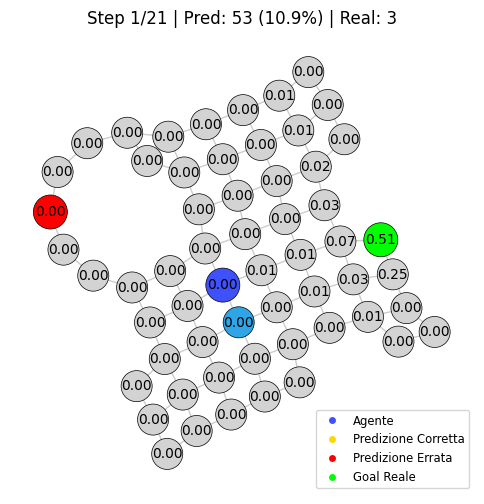

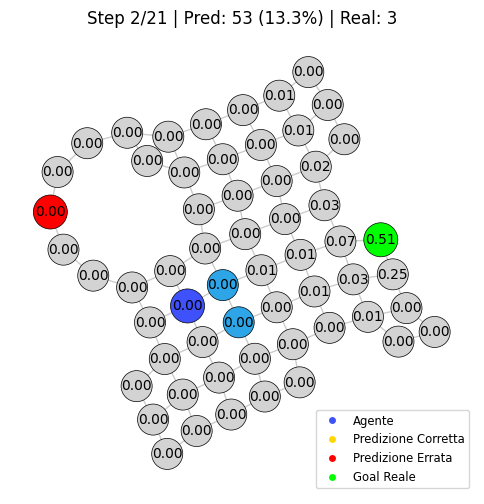

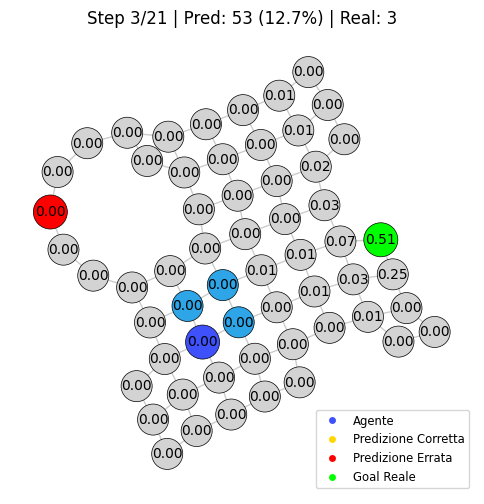

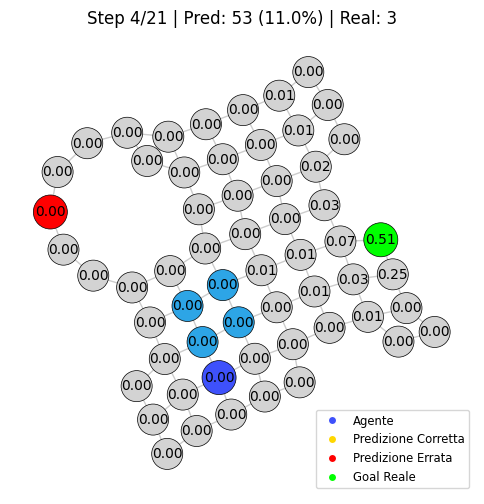

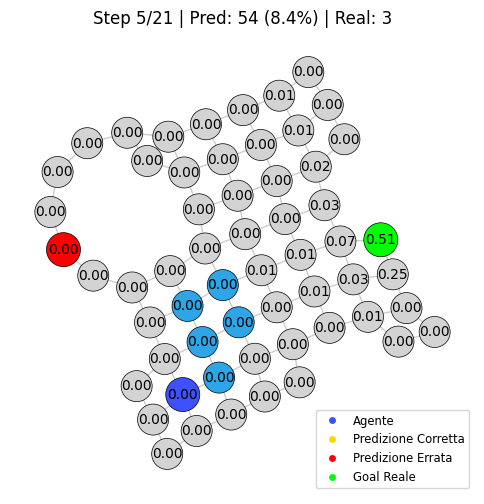

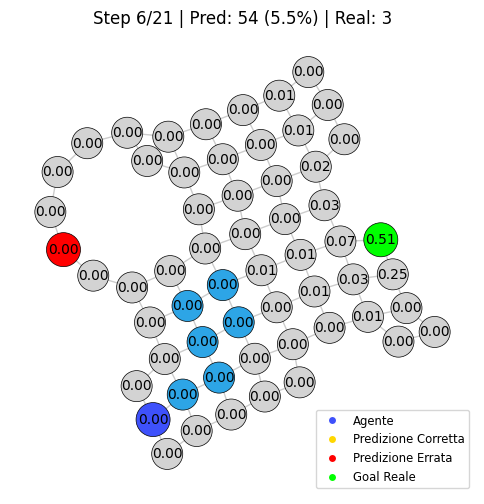

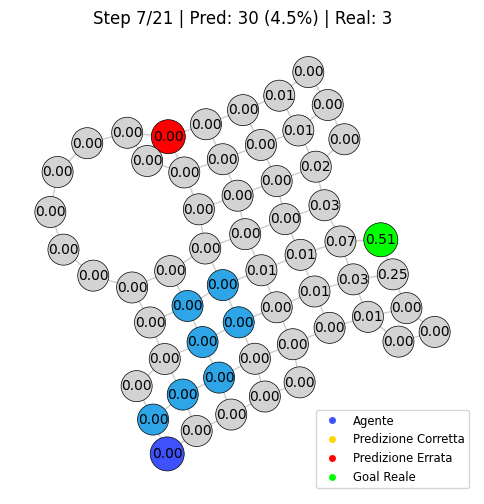

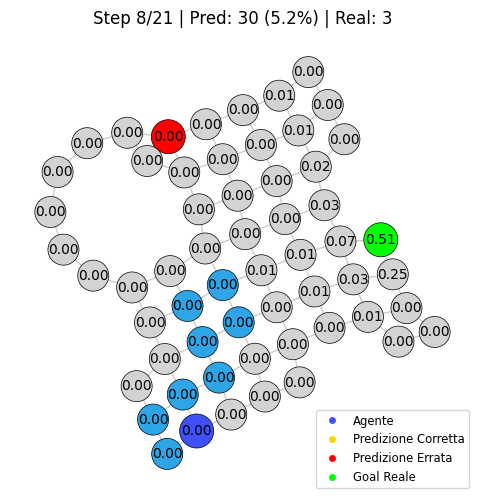

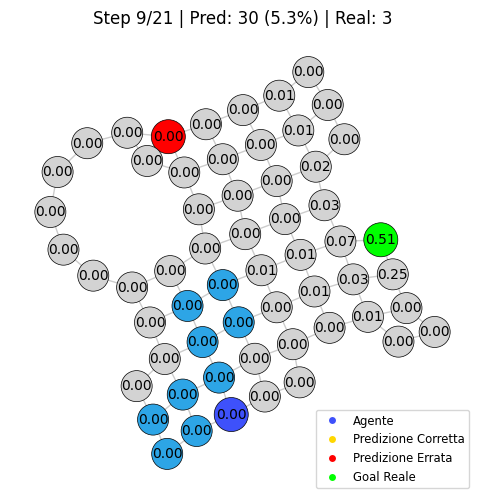

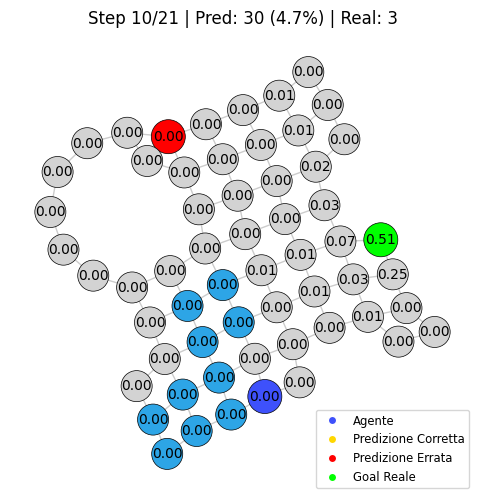

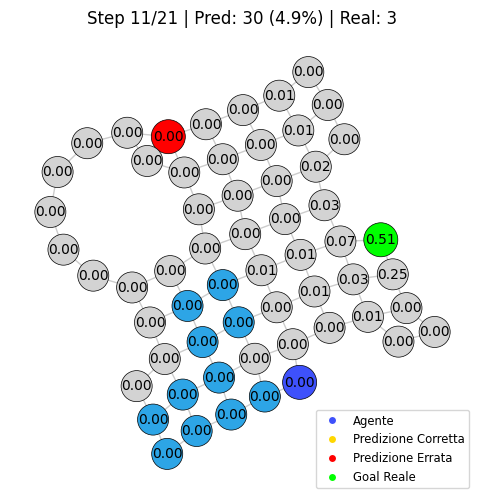

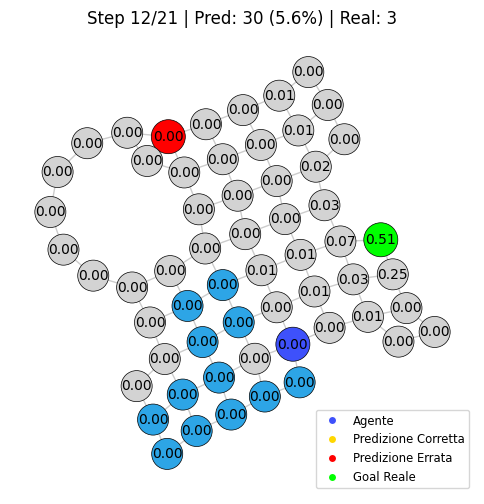

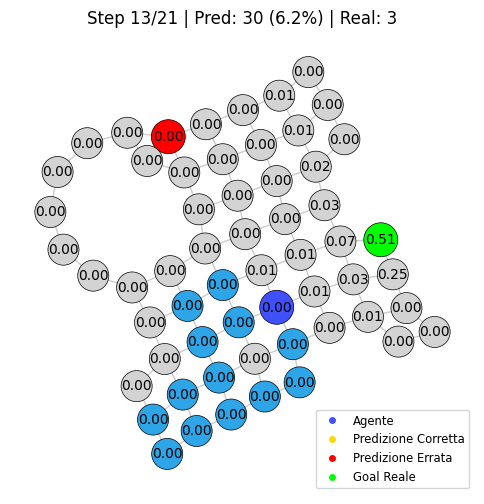

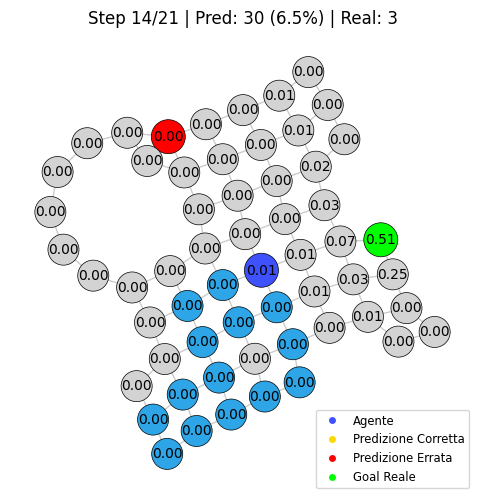

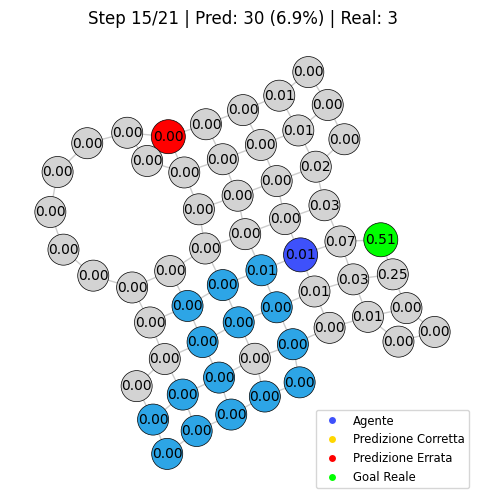

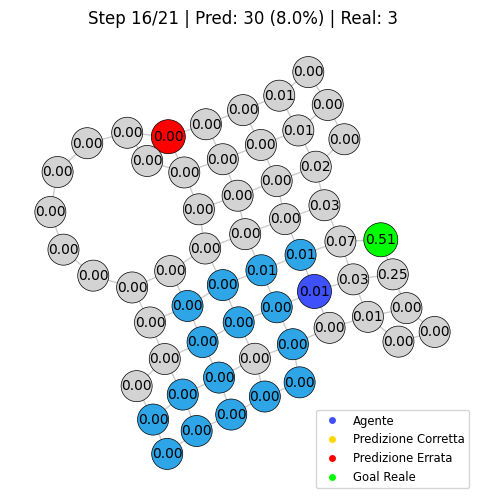

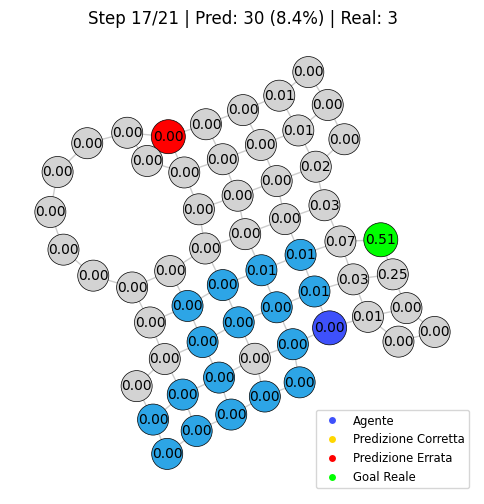

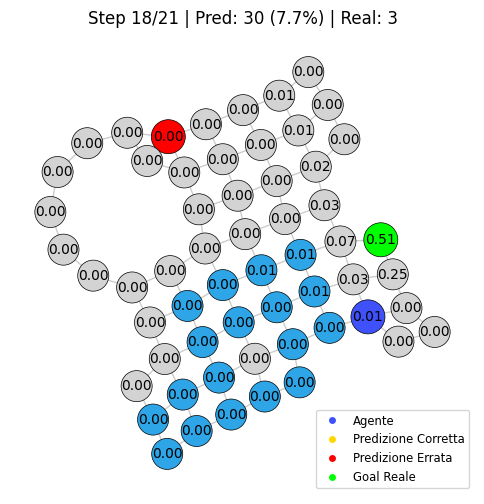

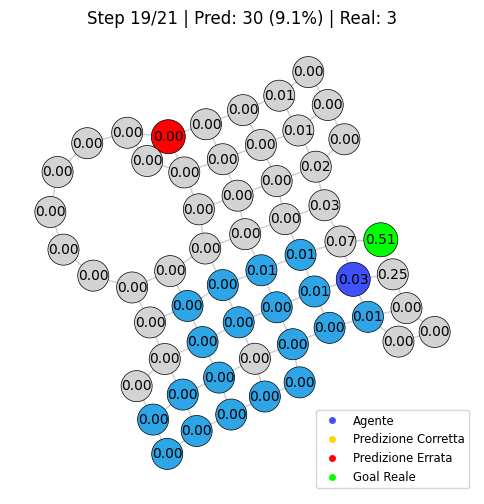

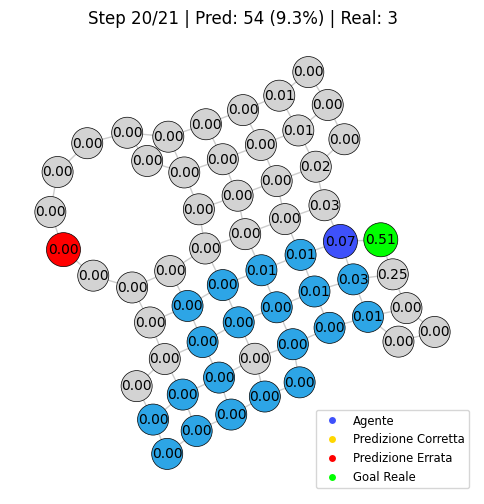

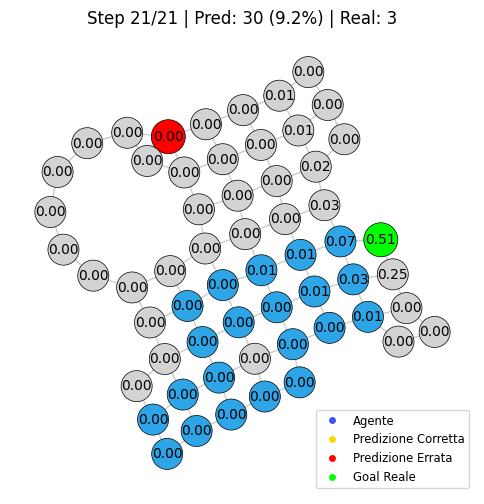

In [67]:
# --- Configurazione ---
mapIndex = 80
pathIndex = 4

# Setup Modello
model_test.eval()
device = next(model_test.parameters()).device 

print(f"\n--- Generazione Sequenza Completa: Mappa {mapIndex}, Percorso {pathIndex} ---")

# 1. Generazione Dati
try:
    # Forziamo percentage=100 per vedere tutto il percorso
    map_and_paths = goalRecognitionDataset.generate_entries(mapIndex, pathIndex, False, 100)
except TypeError:
    map_and_paths = goalRecognitionDataset.generate_entries(mapIndex, pathIndex, False)

print(f"Totale passi da visualizzare: {len(map_and_paths)}\n")

# 2. Setup Layout Fisso (per non far saltare i nodi durante l'animazione)
G_template = to_networkx(map_and_paths[0], to_undirected=True)
fixed_pos = nx.kamada_kawai_layout(G_template) 

# Labels statiche (valori target del dataset)
labels_dict = {i: f"{x:.2f}" for i, x in enumerate(map_and_paths[0].y.tolist())}

# --- Loop Principale ---
for i, data in enumerate(map_and_paths):
    data = data.to(device)
    
    # A. Inference
    with torch.no_grad():
        probs = get_prediction(model_test, data, device)

    # Dati predizione
    pred_idx = probs.argmax().item()
    pred_prob = probs[pred_idx].item()
    true_goal_idx = data.y.argmax().item()

    # B. Calcolo Aspetto Grafico
    colors, sizes = get_node_appearance(data, pred_idx, true_goal_idx)

    # C. Visualizzazione
    info_tuple = (pred_idx, pred_prob, true_goal_idx, i+1, len(map_and_paths))
    plot_simulation_step(data, fixed_pos, colors, sizes, labels_dict, info_tuple)

In [96]:
import pandas as pd
import torch

def collect_test_results(model, loader, device, k=10):
    model.eval()
    results = []
    
    print(f"📊 Avvio raccolta dati (Batch-Corrected) - Top-1 e Top-{k}...")
    
    with torch.no_grad():
        for batch_idx, data in enumerate(loader):
            data = data.to(device)
            
            # Creiamo il batch vector se non esiste (caso singolo grafo)
            batch_vec = data.batch if hasattr(data, 'batch') else torch.zeros(data.num_nodes, dtype=torch.long, device=device)
            
            # Output modello: [Total_Nodes_in_Batch]
            logits = model(data.x, data.edge_index, batch_vec)
            logits = logits.squeeze() # Assicuriamoci sia 1D [N]
            
            # --- ITERIAMO SUI SINGOLI GRAFI DEL BATCH ---
            num_graphs = data.num_graphs
            
            for g_idx in range(num_graphs):
                # 1. Maschera per estrarre solo i nodi del grafo corrente
                mask = (batch_vec == g_idx)
                
                # 2. Estraiamo logits e target solo per questo grafo
                g_logits = logits[mask]
                g_y = data.y[mask]
                
                # 3. Calcolo Probabilità (Softmax sui nodi di QUESTO grafo)
                probs = torch.nn.functional.softmax(g_logits, dim=0)
                
                # 4. Predizioni
                # Top-1
                pred_top1 = probs.argmax().item()
                true_goal = g_y.argmax().item()
                
                # Top-K
                # Gestiamo il caso in cui il grafo ha meno di K nodi
                curr_k = min(k, len(probs))
                _, top_k_indices = torch.topk(probs, curr_k, dim=0)
                
                # 5. Check Correttezza
                is_correct_top1 = (pred_top1 == true_goal)
                # Verifica se il goal reale è nella lista dei top-k indici
                is_correct_topk = (top_k_indices == true_goal).any().item()
                
                confidence = probs[pred_top1].item()
                
                # 6. Salvataggio Dati
                entry = {
                    'is_correct': is_correct_top1,      
                    f'is_top{k}': is_correct_topk,      
                    'confidence': confidence,
                    'true_goal': true_goal,
                    
                    # Metadati (questi sono salvati per grafo, quindi usiamo g_idx)
                    'optimality': data.optimality[g_idx].item(),
                    'obstacle_perc': data.obstacle_perc[g_idx].item(),
                    'path_completion': data.path_completion[g_idx].item(),
                    'avg_len': data.avg_len[g_idx].item()
                }
                results.append(entry)
                
    print(f"✅ Raccolti {len(results)} campioni correttamente.")
    return pd.DataFrame(results)

Generazione grafici comparativi...


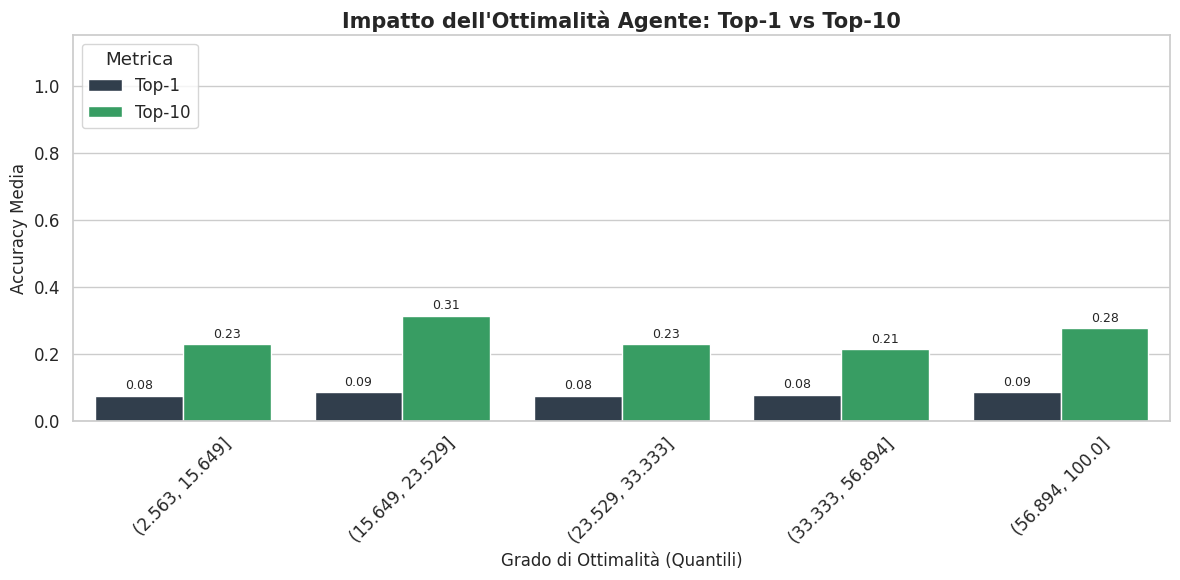

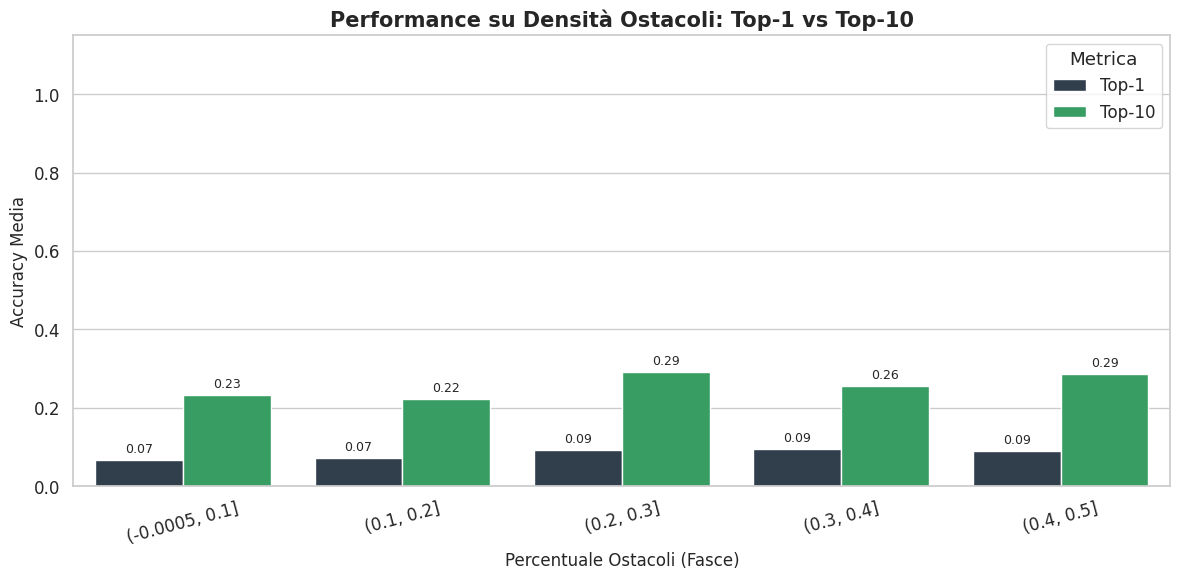

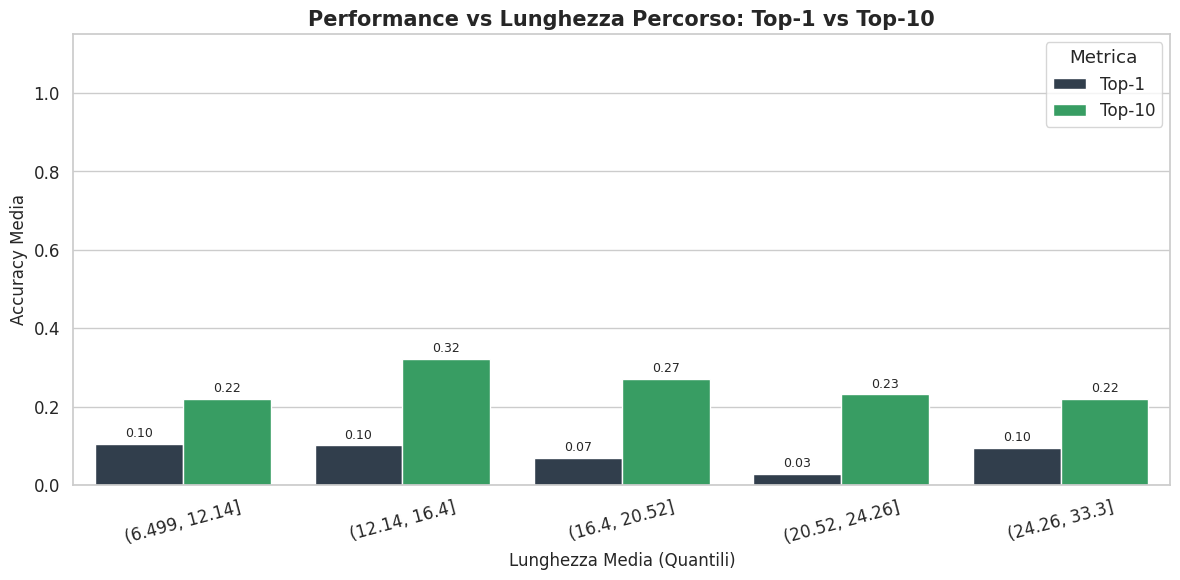

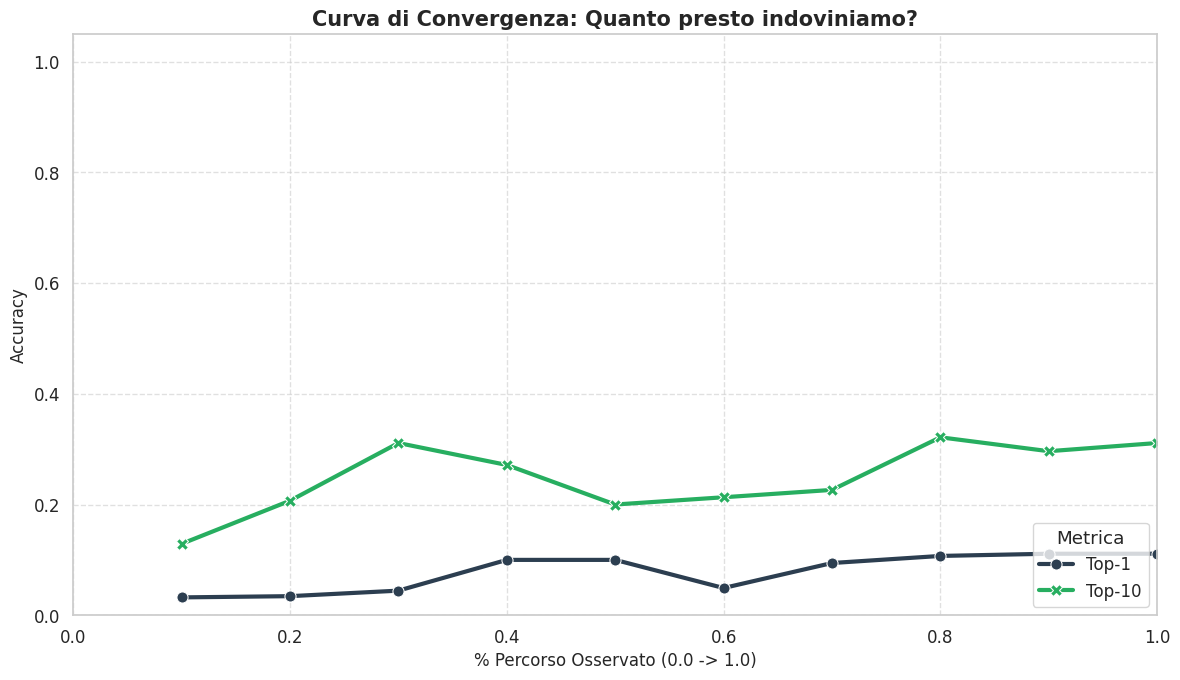

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Imposta stile globale
sns.set_theme(style="whitegrid", context="notebook", font_scale=1.1)
# Palette per distinguere Top-1 da Top-10
COMPARE_PALETTE = {"Top-1": "#2c3e50", "Top-10": "#27ae60"}

def _prepare_comparison_data(df, bin_col, k_label="Top-10"):
    """
    Funzione Helper interna:
    Trasforma il DataFrame in formato 'long' per poter disegnare barre affiancate.
    """
    
    top_k_col = [c for c in df.columns if 'is_top' in c]
    if not top_k_col:
        raise ValueError("Non trovo la colonna is_topX nel dataframe!")
    top_k_col = top_k_col[0] 
    
    grouped = df.groupby(bin_col, observed=False)[[ 'is_correct', top_k_col ]].mean().reset_index()
    
    melted = grouped.melt(id_vars=bin_col, 
                          value_vars=['is_correct', top_k_col],
                          var_name='Metric', value_name='Accuracy')
    
    melted['Metric'] = melted['Metric'].replace({
        'is_correct': 'Top-1', 
        top_k_col: k_label
    })
    
    return melted

# -------------------------------------------------------
# 1. ANALISI OTTIMALITÀ
# -------------------------------------------------------
def plot_optimality_comparison(df):
    plt.figure(figsize=(12, 6))
    
    # 1. Binning
    df_temp = df.copy().dropna(subset=['optimality'])
    try:
        # Tentativo di binning bilanciato (quantili)
        df_temp['opt_bin'] = pd.qcut(df_temp['optimality'], q=5, duplicates='drop')
    except ValueError:
        # Fallback a arrotondamento se i dati sono troppo simili
        df_temp['opt_bin'] = df_temp['optimality'].round(2)
        
    # 2. Preparazione Dati
    plot_data = _prepare_comparison_data(df_temp, 'opt_bin')
    
    # 3. Plot
    ax = sns.barplot(
        data=plot_data, x='opt_bin', y='Accuracy', hue='Metric',
        palette=COMPARE_PALETTE
    )
    
    plt.title("Impatto dell'Ottimalità Agente: Top-1 vs Top-10", fontsize=15, fontweight='bold')
    plt.xlabel("Grado di Ottimalità (Quantili)", fontsize=12)
    plt.ylabel("Accuracy Media", fontsize=12)
    plt.ylim(0, 1.15) # Un po' più spazio per la legenda
    plt.legend(title="Metrica", loc='upper left')
    plt.xticks(rotation=45)
    
    # Annotazioni (valori sulle barre)
    for p in ax.patches:
        h = p.get_height()
        if h > 0:
            ax.annotate(f'{h:.2f}', (p.get_x() + p.get_width()/2, h), 
                        ha='center', va='bottom', fontsize=9, xytext=(0,3), textcoords='offset points')
            
    plt.tight_layout()
    plt.show()


# -------------------------------------------------------
# 2. ANALISI OSTACOLI
# -------------------------------------------------------
def plot_obstacles_comparison(df):
    plt.figure(figsize=(12, 6))
    
    df_temp = df.copy()
    # Binning fisso per percentuale (0-20%, 20-40%...)
    df_temp['obs_bin'] = pd.cut(df_temp['obstacle_perc'], bins=5)
    
    plot_data = _prepare_comparison_data(df_temp, 'obs_bin')
    
    ax = sns.barplot(
        data=plot_data, x='obs_bin', y='Accuracy', hue='Metric',
        palette=COMPARE_PALETTE
    )
    
    plt.title("Performance su Densità Ostacoli: Top-1 vs Top-10", fontsize=15, fontweight='bold')
    plt.xlabel("Percentuale Ostacoli (Fasce)", fontsize=12)
    plt.ylabel("Accuracy Media", fontsize=12)
    plt.ylim(0, 1.15)
    plt.legend(title="Metrica", loc='upper right')
    plt.xticks(rotation=15)
    
    for p in ax.patches:
        h = p.get_height()
        if h > 0:
            ax.annotate(f'{h:.2f}', (p.get_x() + p.get_width()/2, h), 
                        ha='center', va='bottom', fontsize=9, xytext=(0,3), textcoords='offset points')

    plt.tight_layout()
    plt.show()


# -------------------------------------------------------
# 3. LUNGHEZZA PERCORSO
# -------------------------------------------------------
def plot_avg_len_comparison(df):
    plt.figure(figsize=(12, 6))
    
    df_temp = df.copy()
    try:
        df_temp['len_bin'] = pd.qcut(df_temp['avg_len'], q=5, duplicates='drop')
    except ValueError:
        df_temp['len_bin'] = pd.cut(df_temp['avg_len'], bins=5)
        
    plot_data = _prepare_comparison_data(df_temp, 'len_bin')
    
    ax = sns.barplot(
        data=plot_data, x='len_bin', y='Accuracy', hue='Metric',
        palette=COMPARE_PALETTE
    )
    
    plt.title("Performance vs Lunghezza Percorso: Top-1 vs Top-10", fontsize=15, fontweight='bold')
    plt.xlabel("Lunghezza Media (Quantili)", fontsize=12)
    plt.ylabel("Accuracy Media", fontsize=12)
    plt.ylim(0, 1.15)
    plt.legend(title="Metrica", loc='upper right')
    plt.xticks(rotation=15)
    
    for p in ax.patches:
        h = p.get_height()
        if h > 0:
            ax.annotate(f'{h:.2f}', (p.get_x() + p.get_width()/2, h), 
                        ha='center', va='bottom', fontsize=9, xytext=(0,3), textcoords='offset points')

    plt.tight_layout()
    plt.show()


# -------------------------------------------------------
# 4. EARLY PREDICTION
# -------------------------------------------------------
def plot_early_prediction_comparison(df):
    plt.figure(figsize=(12, 7))
    
    df_temp = df.copy()
    df_temp['completion_bin'] = df_temp['path_completion'].round(1)
    
    plot_data = _prepare_comparison_data(df_temp, 'completion_bin')
    
    # Lineplot gestisce 'hue' disegnando due linee separate
    sns.lineplot(
        data=plot_data, x='completion_bin', y='Accuracy', hue='Metric',
        palette=COMPARE_PALETTE, style='Metric', markers=True, dashes=False, linewidth=3, markersize=8
    )
    
    plt.title("Curva di Convergenza: Quanto presto indoviniamo?", fontsize=15, fontweight='bold')
    plt.xlabel("% Percorso Osservato (0.0 -> 1.0)", fontsize=12)
    plt.ylabel("Accuracy", fontsize=12)
    plt.ylim(0, 1.05)
    plt.xlim(0, 1.0)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(title="Metrica", loc='lower right')
    
    plt.tight_layout()
    plt.show()

# -------------------------------------------------------
# ESECUZIONE DI TUTTI I GRAFICI
# -------------------------------------------------------
print("Generazione grafici comparativi...")
plot_optimality_comparison(df_results)
plot_obstacles_comparison(df_results)
plot_avg_len_comparison(df_results)
plot_early_prediction_comparison(df_results)

In [92]:
print("--- VERIFICA DATI ATTUALI ---")
acc_top1 = df_results['is_correct'].mean() * 100

# Cerca la colonna top-k dinamica
top_k_col = [c for c in df_results.columns if 'is_top' in c][0]
acc_topk = df_results[top_k_col].mean() * 100

print(f"Media nel DataFrame Top-1:  {acc_top1:.2f}%")
print(f"Media nel DataFrame {top_k_col}: {acc_topk:.2f}%")

--- VERIFICA DATI ATTUALI ---
Media nel DataFrame Top-1:  8.03%
Media nel DataFrame is_top10: 25.24%


📊 Avvio raccolta risultati (Top-1 vs Top-10)...
📊 Avvio raccolta dati (Batch-Corrected) - Top-1 e Top-10...
✅ Raccolti 16733 campioni correttamente.

Generazione Grafici Comparativi...


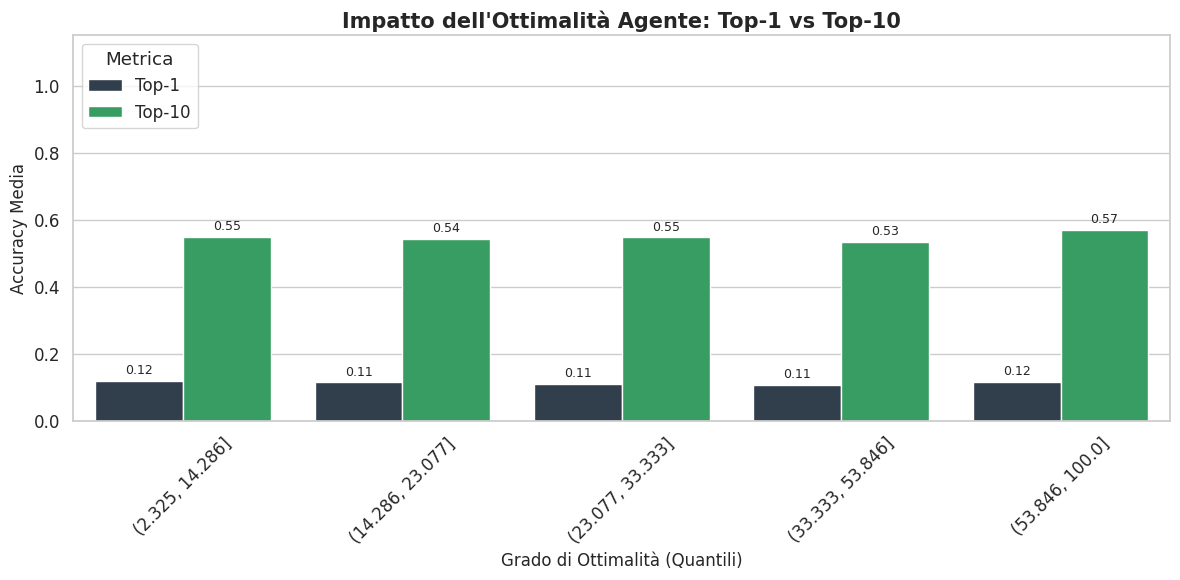

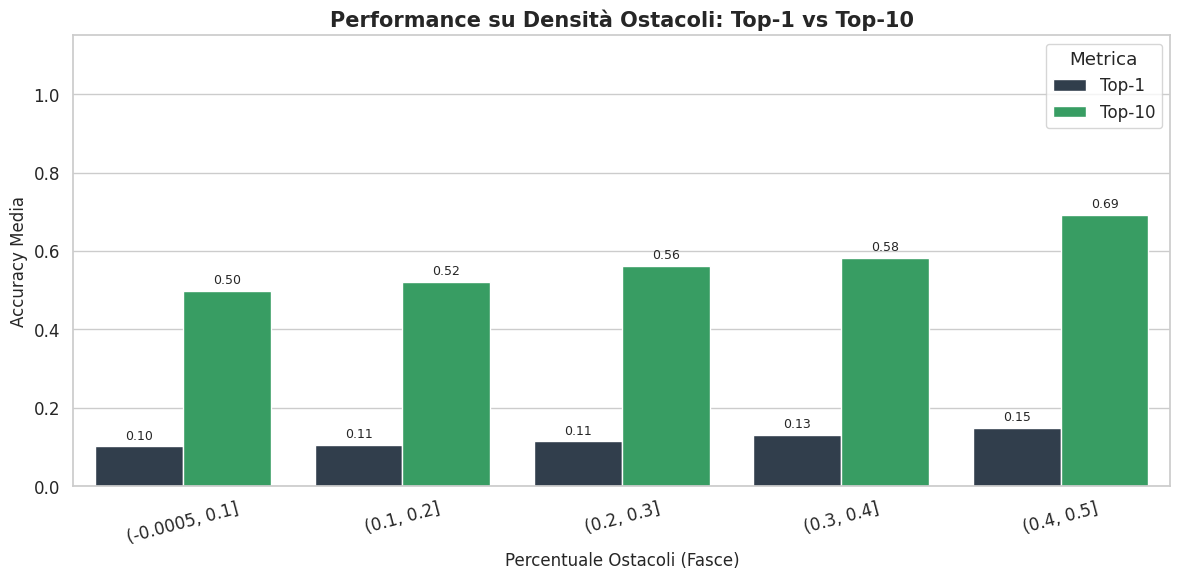

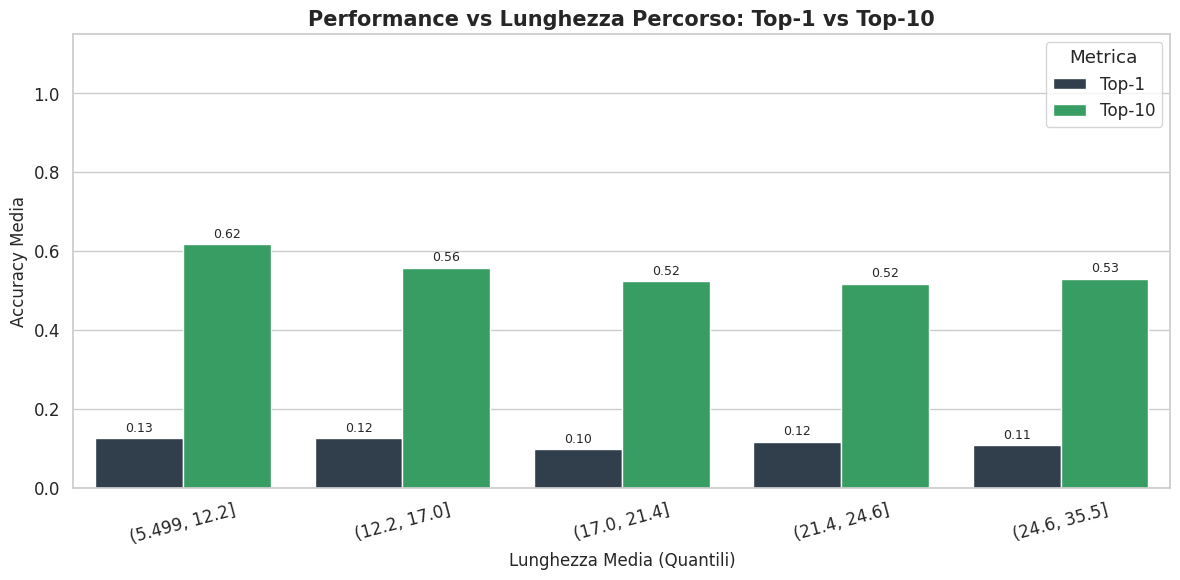

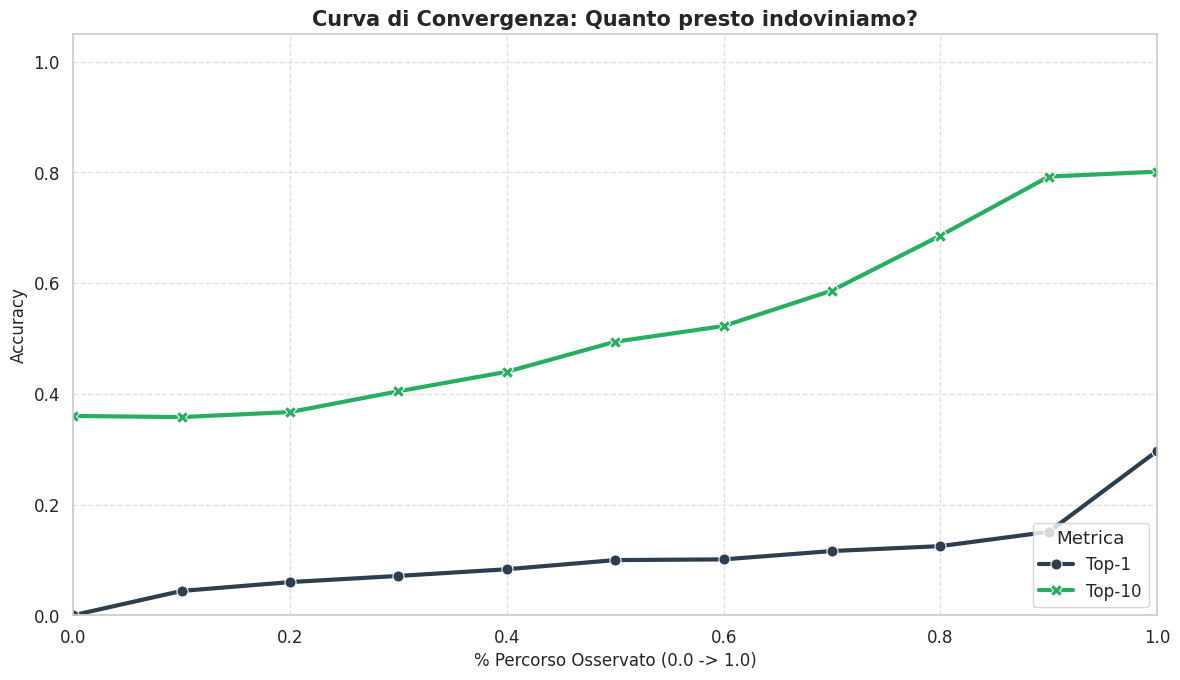


=== RISULTATI FINALI (Run i6s65bid) ===
Test Top-1 Accuracy  : 11.40%
Test Top-10 Accuracy : 54.88%


In [97]:
# --- CONFIGURAZIONE ANALISI ---
K_VALUE = 10  # Analizziamo la Top-10

# 1. Raccolta Dati sul Test Set
# Nota: usa 'model_test' caricato nel blocco precedente
if 'model_test' in globals():
    print(f"📊 Avvio raccolta risultati (Top-1 vs Top-{K_VALUE})...")
    df_results = collect_test_results(model_test, test_loader, device, k=K_VALUE)
    
    # 2. Generazione Grafici
    print("\nGenerazione Grafici Comparativi...")
    
    # Ottimalità
    plot_optimality_comparison(df_results)
    
    # Ostacoli
    plot_obstacles_comparison(df_results)
    
    # Lunghezza Percorso
    plot_avg_len_comparison(df_results)
    
    # Early Prediction (Convergenza temporale)
    plot_early_prediction_comparison(df_results)
    
    # 3. Stampa Metriche Numeriche finali
    acc_top1 = df_results['is_correct'].mean() * 100
    
    # Trova dinamicamente la colonna top-k
    top_k_col = [c for c in df_results.columns if 'is_top' in c][0]
    acc_topk = df_results[top_k_col].mean() * 100
    
    print(f"\n=== RISULTATI FINALI (Run {best_run_id}) ===")
    print(f"Test Top-1 Accuracy  : {acc_top1:.2f}%")
    print(f"Test Top-{K_VALUE} Accuracy : {acc_topk:.2f}%")
    print("==========================================")

else:
    print("❌ Errore: 'model_test' non trovato. Esegui prima il Blocco 1!")